### Johdanto datatieteeseen
# Tampereen kaksiot

Tämän notebookin tarkoituksena on raapia dataa Tampereen kaksioista Etuovi.com -sivustolta, siistiä sitä, tunnistaa merkittävät ominaisuudet, sekä luoda pari erilaista regressiomallia sen pohjalta. Päätin kokeilla rakentaa hybridimallin, joka ensin luokittelee asuinalueen annetuilla lähtötiedoilla ja tämän jälkeen arvioi asunnon hinnan ottaen huomioon luokitellun asuinalueen.

## Tarvittavat kirjastot

In [218]:
# Tarvittavien kirjastojen tuominen.
from bs4 import BeautifulSoup as bs
from IPython.display import clear_output
from requests import get
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, os

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
current_time = time.time()

le = LabelEncoder()
ss = StandardScaler()

print('Done importing')

Done importing


## Datan raapiminen

In [219]:
# Raapimiseen tarvittavien taustatietojen hakeminen, ja määrittäminen.
useLocal = True  # Käytetäänkö pelkästään paikallista dataa, vai raavitaanko uutta lisäksi
fileName = 'tampere_kaksiot_etuovi.csv'
headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
baseUrl = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481024326&sivu='
html = get(baseUrl, headers=headers)
soup = bs(html.text, 'html.parser')

houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")
tabs = soup.find_all('button', class_="theme__button__1YqFK theme__flat__13aFK theme__button__1YqFK theme__squared__17Uvn theme__neutral__1F1Jf Button__button__3K-jn Pagination__button__3H2wX")
max_tab = int(tabs[-1].contents[0])
print('Parameters set.')

Parameters set.


In [220]:

if useLocal:
    df = pd.read_csv(f'./data/{fileName}', index_col=0)
    print('Local data found! Imported to DataFrame.')
else:
    loadingBar = []
    limit = 0.1
    data = {
    'Alue': [],
    'Osoite': [],
    'Hinta': [],
    'Koko': [],
    'Vuosi': [],
    'Talotyyppi': [],
    'Sauna': [],
    'Parveke': [],
    }

    for i in range(max_tab):
        clear_output(wait=True)

        baseUrl = f'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481187938&sivu={i+1}'
        html = get(baseUrl, headers=headers)
        soup = bs(html.text, 'html.parser')

        houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")

        for temp in houseCards:
            spans = temp.find_all('span', class_='')

            isSize = False
            isPrice = False
            isYear = False

            for item in spans:
                if isPrice:
                    price = item.contents[0].replace('\xa0', '')[:-1]
                    price = float(price.replace(',','.'))
                    isPrice = False
                elif isSize:
                    try:
                        size = float(item.contents[0].replace(',', '.'))
                    except ValueError:
                        size = None
                    isSize = False
                elif isYear:
                    try:
                        year = int(item.contents[0])
                    except ValueError:
                        year = None
                    isYear = False
                else:

                    if 'Hinta' in item.contents and 'Hintamuutos' not in item.contents:
                        isPrice = True
                    elif 'Koko' in item.contents:
                        isSize = True
                    elif 'Vuosi' in item.contents:
                        isYear = True

            raw_address = temp.find('h4').contents[0]
            try:
                address, area, city_ = raw_address.split(', ') # Osoite, Alue
                street = address.split(' ')[0]
            except ValueError:
                address, city = raw_address.split(', ')
                if 'Opiskelijankatu' in address:
                    area = 'Hervanta'

            raw_type = temp.find('h5').contents[0]
            try:
                house_type, raw_attributes = raw_type.split(' | ') # Talotyyppi
                attributes = raw_attributes.split(' + ') # Ominaisuudet
            except ValueError:
                house_type = raw_type


            data['Alue'].append(area.strip())
            data['Osoite'].append(address.strip())
            data['Katu'].append(street.strip())
            data['Hinta'].append(price)
            data['Koko'].append(size)
            data['Vuosi'].append(year)
            data['Talotyyppi'].append(house_type.strip())
            if 's' in attributes:
                sauna = True
            else:
                sauna = False
            if 'p' in attributes:
                balcony = True
            else:
                for item in attributes:
                    if 'parveke' in item:
                        balcony = True
                else:
                    balcony = False

            data['Sauna'].append(sauna)
            data['Parveke'].append(balcony)
        
        if i/max_tab >= limit:
            loadingBar.append('#')
            limit += 0.1
        print('{}{:10}{}'.format('|', ''.join(loadingBar), '|'),'Scraping data...')
        
    df = pd.DataFrame(data)
    if fileName in os.listdir('./data/'):
        local_df = pd.read_csv(f'./data/{fileName}')
        dt = time.asctime(time.localtime(st.st_ctime))
        wd, m, d, t, y = dt.split(' ')
        h, min_, s = t.split(':')
        fname = f'{h}-{min_}-{s}_{d}_{m}_{y}'
        os.rename(f'./data/{fileName}', f'./data/{fname}.csv')
        pd.concat([df,local_df]).drop_duplicates().reset_index(drop=True)

    df.to_csv(f'./data/{fileName}')
    print('Done scraping',)
print(f'{len(df)} rows loaded.')

Local data found! Imported to DataFrame.
990 rows loaded.


Nyt raavittu data on käytettävissä pandas-kirjaston hyödyllisessä DataFrame -taulukkoformaatissa. Nyt voidaan jatkaa datan tarkasteluun ja siistimiseen.


## Datan tarkastelu ja siistiminen

In [223]:
df.head()

Alue                Osoite     Hinta  Koko   Vuosi  Talotyyppi  Sauna  \
0  Muotiala     Muotialantie 74 C  208000.0  54.0  2008.0   Luhtitalo  False   
1    Kaleva         Teiskontie 13  218000.0  60.0  1954.0  Kerrostalo  False   
2    Kaleva    Lemminkäisenkatu 6  185000.0  52.5  1960.0  Kerrostalo  False   
3   Tammela        Välimaankatu 7  178000.0  48.6  1932.0  Kerrostalo  False   
4     Amuri  Kortelahdenkatu 18 B  174000.0  40.0  1970.0  Kerrostalo  False   

   Parveke              Katu  
0    False      Muotialantie  
1    False        Teiskontie  
2    False  Lemminkäisenkatu  
3    False      Välimaankatu  
4    False   Kortelahdenkatu

In [224]:
# Tilastollisia tietoja datan numeerisista muuttujista
df.describe()

Hinta        Koko        Vuosi
count     990.000000  989.000000   989.000000
mean   215244.411548   47.330435  2008.915066
std     83059.223160    9.531051    22.599149
min     32000.000000   29.000000  1920.000000
25%    163200.000000   39.000000  2013.000000
50%    199900.000000   46.000000  2020.000000
75%    247900.000000   54.000000  2021.000000
max    708550.000000   93.500000  2022.000000

In [225]:
# Tietoja datasarakkeiden määristä ja tyypeistä
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 989
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        990 non-null    object 
 1   Osoite      990 non-null    object 
 2   Hinta       990 non-null    float64
 3   Koko        989 non-null    float64
 4   Vuosi       989 non-null    float64
 5   Talotyyppi  990 non-null    object 
 6   Sauna       990 non-null    bool   
 7   Parveke     990 non-null    bool   
 8   Katu        990 non-null    object 
dtypes: bool(2), float64(3), object(4)
memory usage: 103.8+ KB


Viimeisimmän komennon tulosteesta voidaan nähdä joissakin sarakkeissa olevan puuttuvia arvoja (22.4.2020). Korvataan puuttuvat numeeriset arvot aluekohtaisilla keskiarvoilla.

In [226]:
colsWithNan = df.columns[df.isna().any()].tolist()

for col in colsWithNan:
    df[col].fillna(round(df[col].mean()), inplace=True)

df.Vuosi = df.Vuosi.astype('int')
""" df.Sauna = df.Sauna.astype('int')
df.Parveke = df.Parveke.astype('int') """
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 989
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        990 non-null    object 
 1   Osoite      990 non-null    object 
 2   Hinta       990 non-null    float64
 3   Koko        990 non-null    float64
 4   Vuosi       990 non-null    int32  
 5   Talotyyppi  990 non-null    object 
 6   Sauna       990 non-null    bool   
 7   Parveke     990 non-null    bool   
 8   Katu        990 non-null    object 
dtypes: bool(2), float64(2), int32(1), object(4)
memory usage: 99.9+ KB


Nyt puuttuvia arvoja ei enää ole. Visualisoidaan seuraavaksi hiukan datan sisältöä.

In [227]:
df['m2-hinta'] = df.Hinta / df.Koko

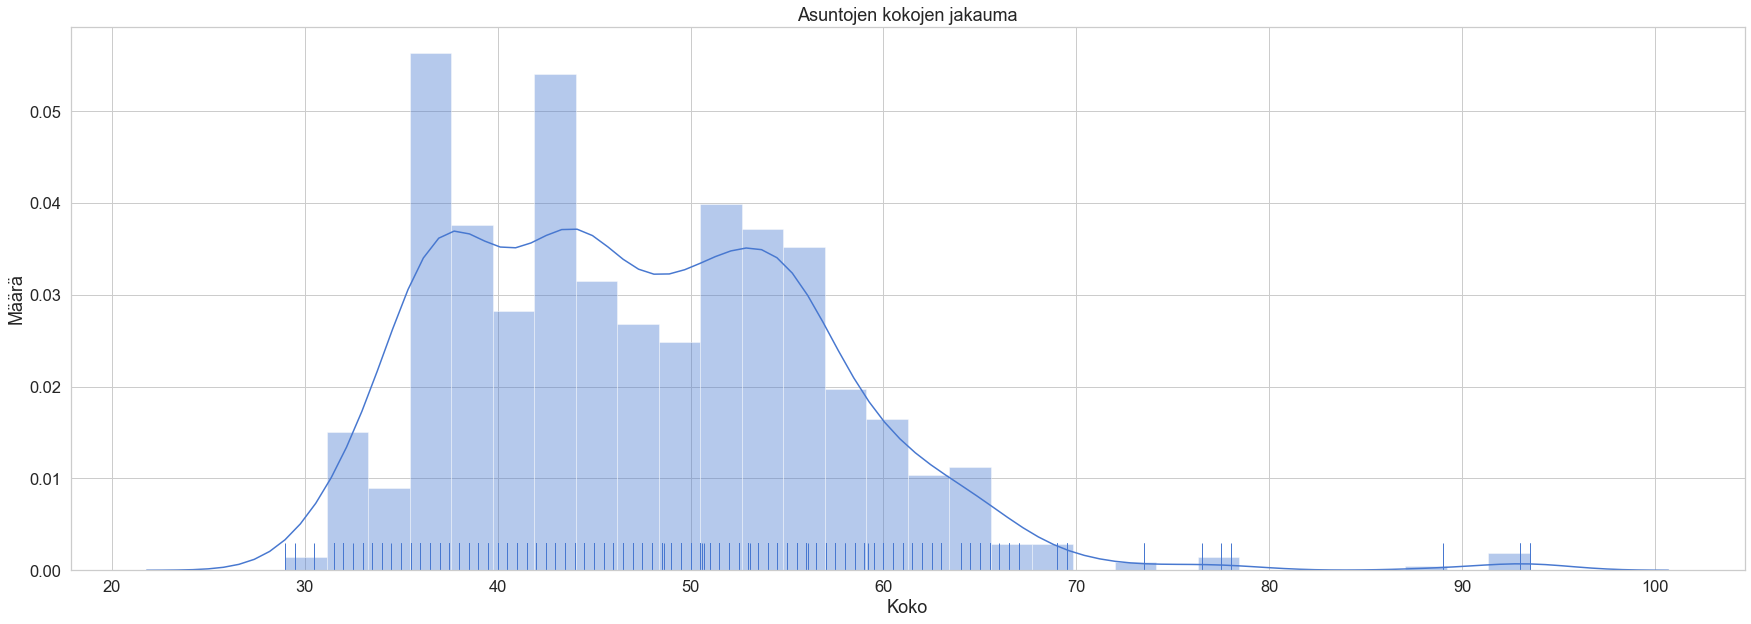

In [228]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen kokojen jakauma')
plt.xlabel('Asunnon koko neliömetreissä')
plt.ylabel('Määrä')
#df['Koko'].value_counts().plot(kind='bar');
sns.distplot(df.Koko, rug=True, bins=30);

Asuntojen koot asettuvat pääosin 30 ja 70 neliömetrin välille.

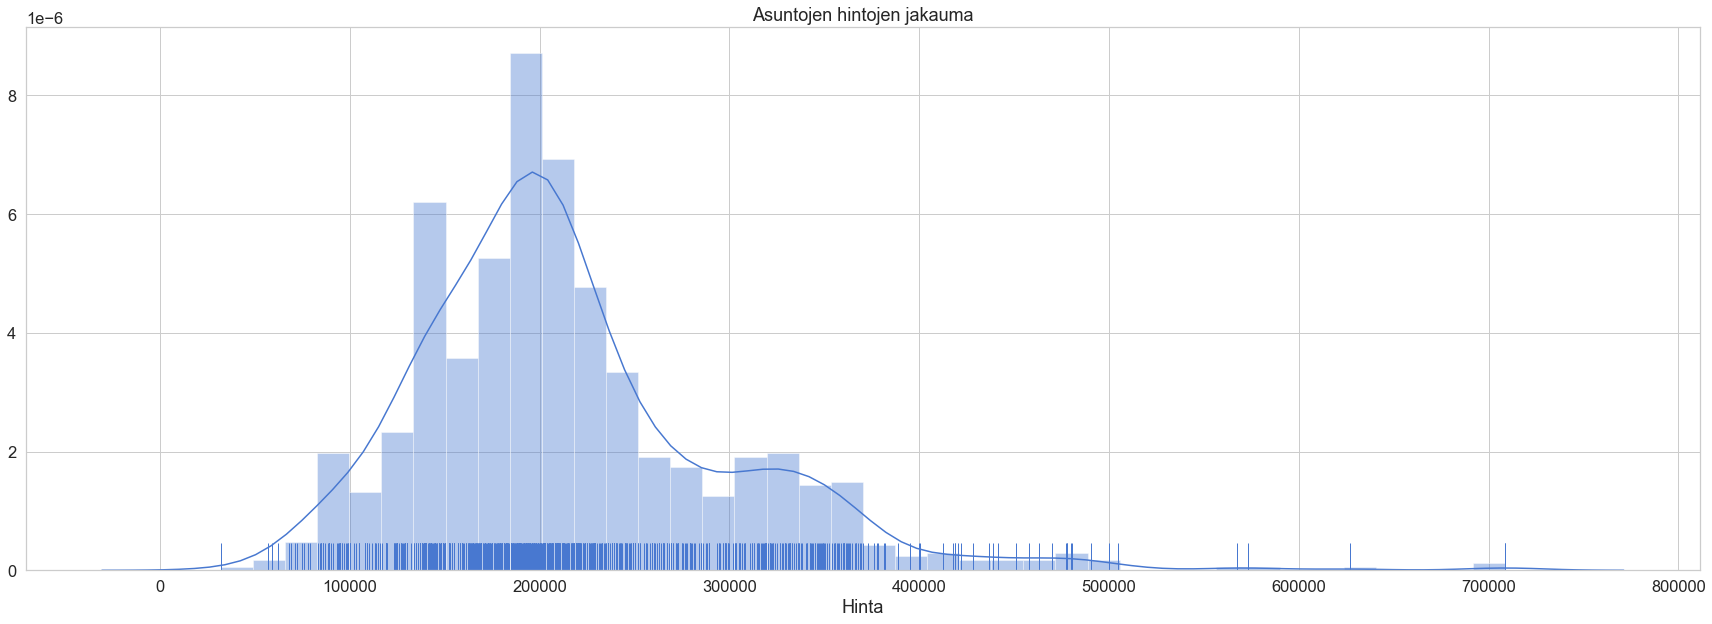

In [229]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen hintojen jakauma')
sns.distplot(df['Hinta'], rug=True);

Hinnat painottuvat vahvasti 200 000 euron ympäristöön.

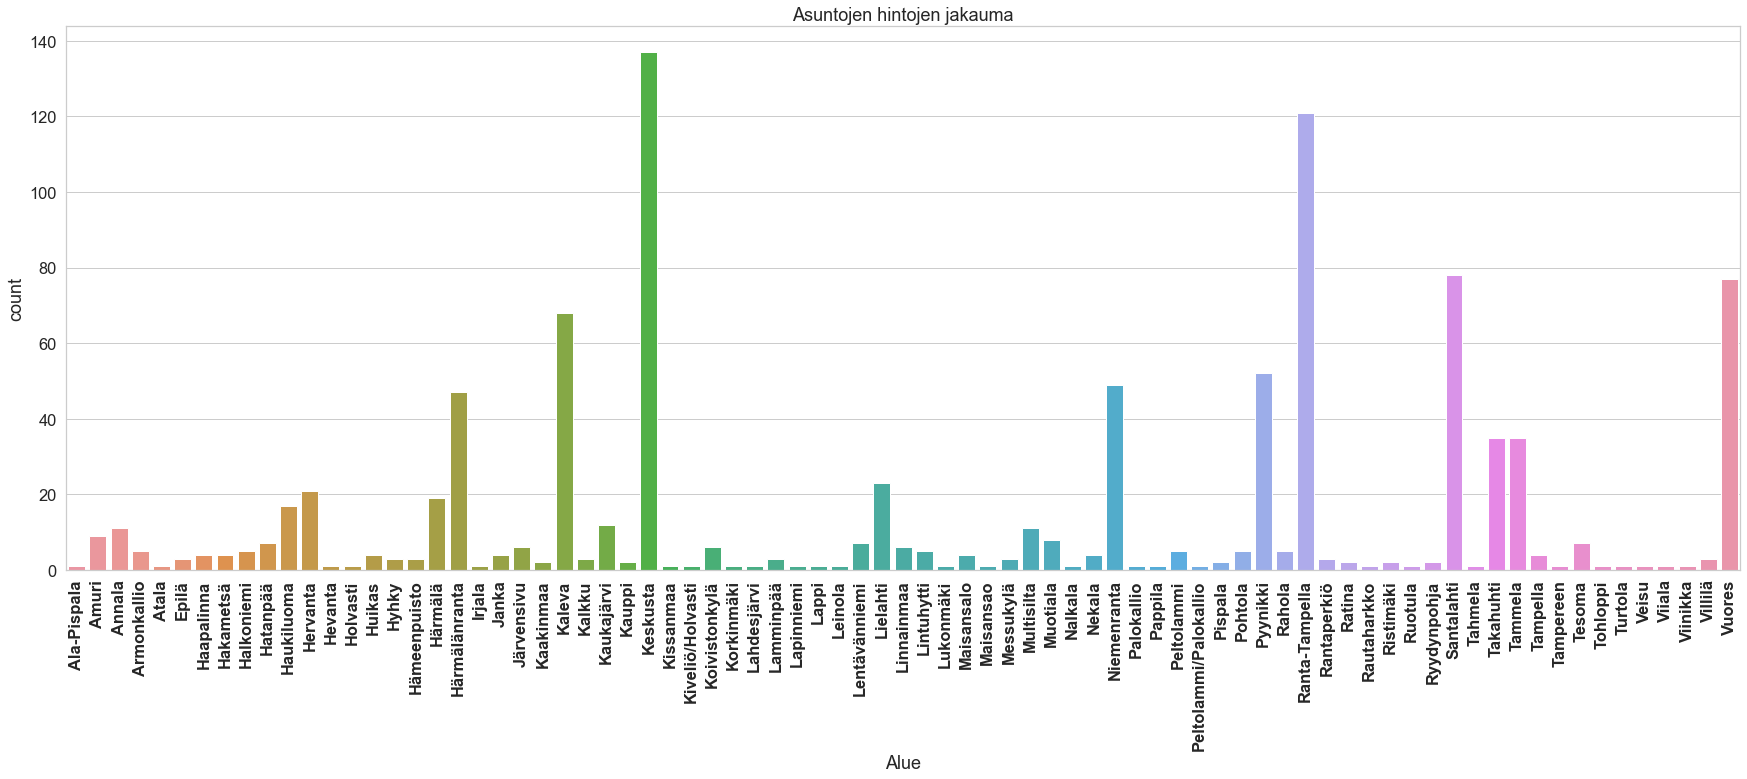

In [230]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen hintojen jakauma')
sns.countplot(x=df.Alue.sort_values())
plt.xticks(weight='bold',rotation=90,);

Nähdään aluekohtaisten ilmoitusmäärien erojen olevan paikoittain suuria.

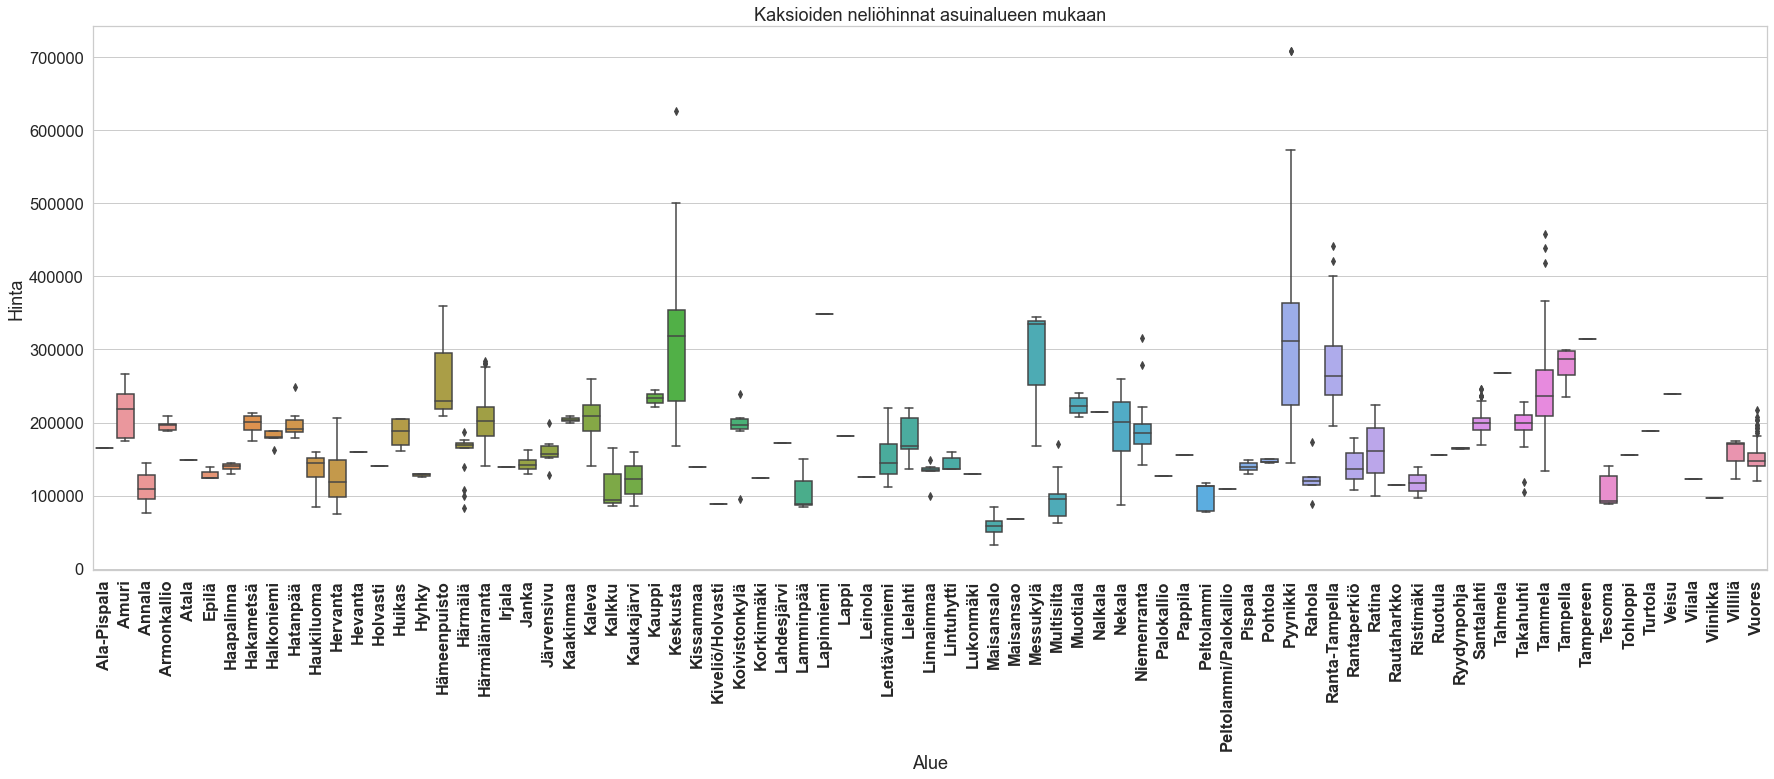

In [231]:
plt.figure(figsize=(30,10))
sns.boxplot(x=df.Alue.sort_values(ascending=True), y=df['Hinta'],);
plt.title('Kaksioiden neliöhinnat asuinalueen mukaan')
plt.xticks(weight='bold',rotation=90);

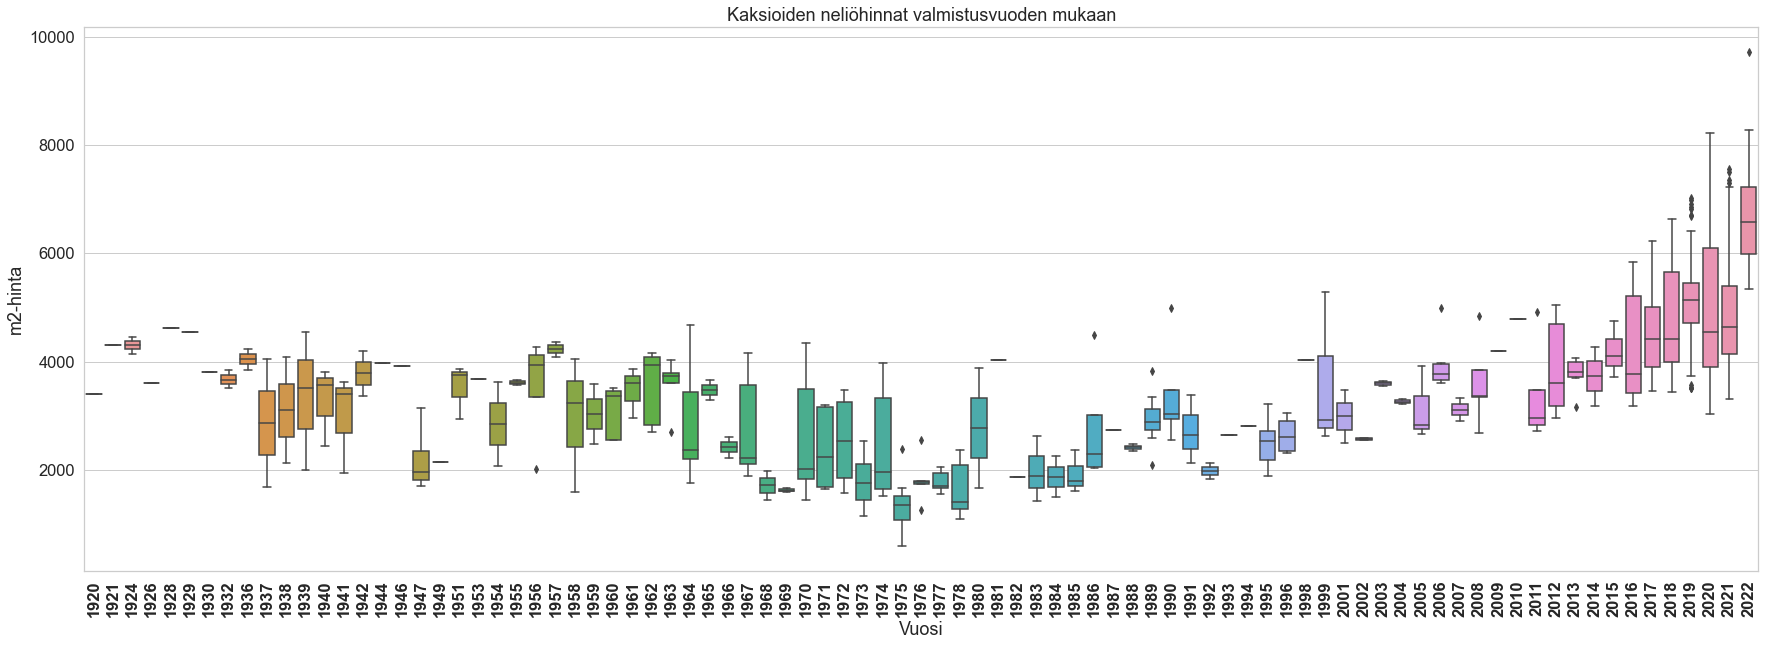

In [232]:
plt.figure(figsize=(30,10))
sns.boxplot(x=df.Vuosi, y=df['m2-hinta']);
plt.title('Kaksioiden neliöhinnat valmistusvuoden mukaan')
plt.xticks(weight='bold',rotation=90);

Myytävänä olevat asunnot ovat kuvaajan perusteella hyvin uusia, ja osa jopa vielä rakennuksvaiheessa olevia. Hinnat näyttävät muodostavan U-muotoa, eli 70-luvulla rakennettujen asuntojen hinnat vaikuttavat olevan matalimpia, ja siitä vanhempien ja uudempien asuntojen hinnat kasvavat. 

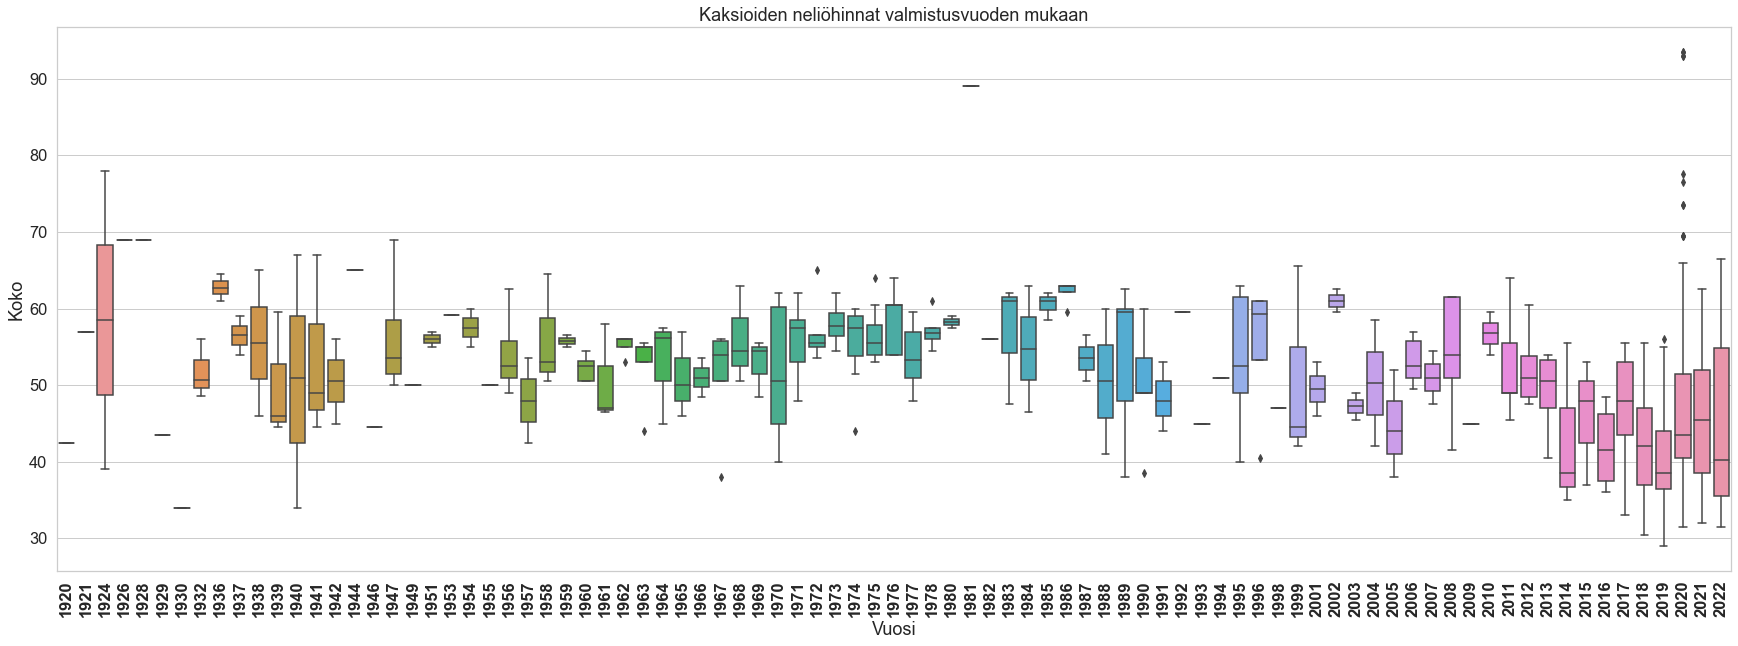

In [233]:
plt.figure(figsize=(30,10))
sns.boxplot(x=df.Vuosi, y=df['Koko']);
plt.title('Kaksioiden neliöhinnat valmistusvuoden mukaan')
plt.xticks(weight='bold',rotation=90);

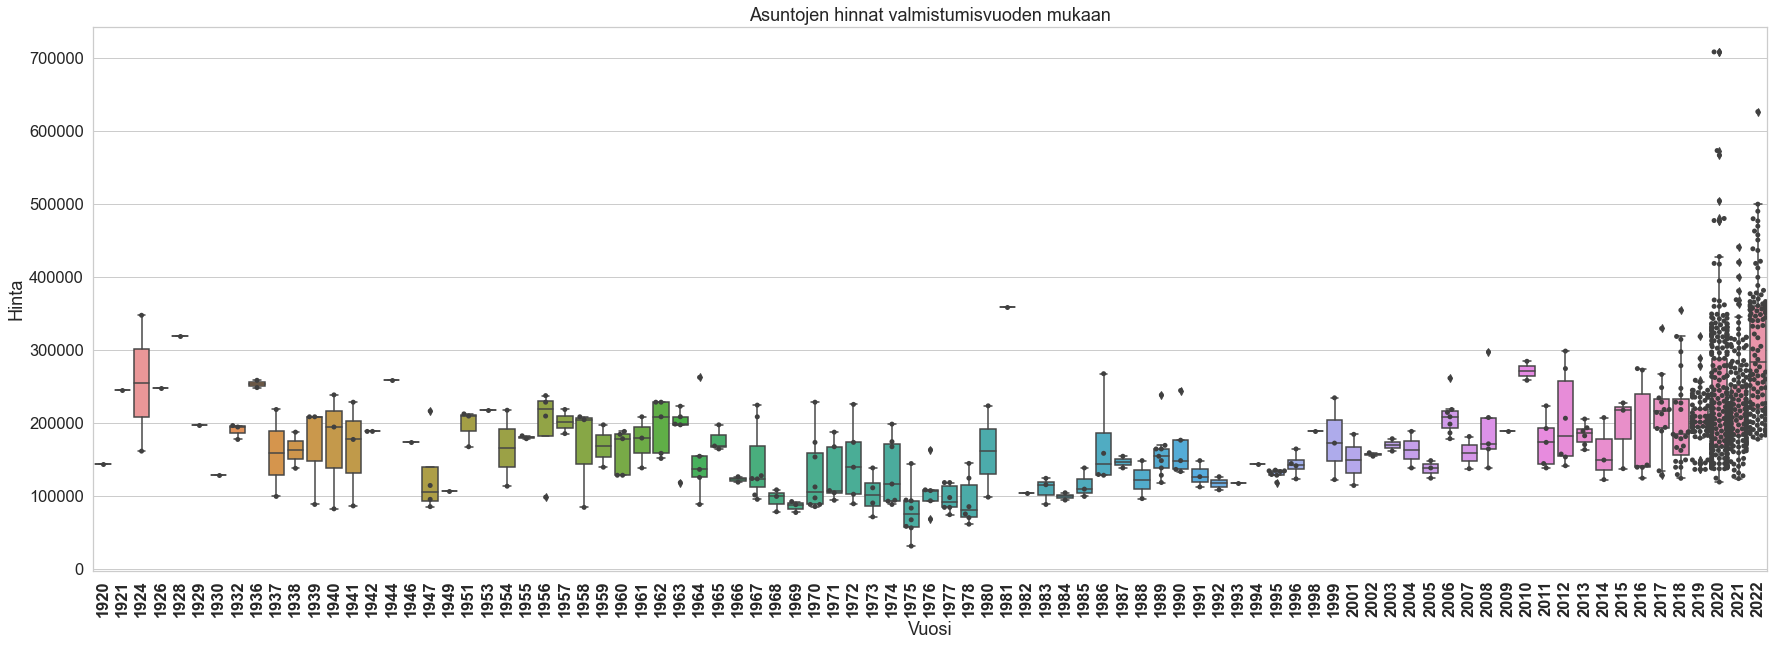

In [234]:
plt.figure(figsize=(30,10))

sns.boxplot(x='Vuosi', y="Hinta", data=df,)
sns.swarmplot(x='Vuosi', y="Hinta", data=df, color=".25",)
plt.title('Asuntojen hinnat valmistumisvuoden mukaan');
plt.xticks(weight='bold',rotation=90,);

## Oleellisten piirteiden tunnistaminen

Aloitetaan korvaamalla kategoriset muuttujat numeerisilla korvikkeilla.

In [235]:
print(f'Before\n{df.dtypes}')

for col in df.columns:
    if df[col].dtype == 'object' and col != 'Osoite':
        newColName = f'{col}_'
        fit = le.fit(df[col])
        df[newColName] = fit.transform(df[col])
print(f'\nAfter\n{df.dtypes}')

Before
Alue           object
Osoite         object
Hinta         float64
Koko          float64
Vuosi           int32
Talotyyppi     object
Sauna            bool
Parveke          bool
Katu           object
m2-hinta      float64
dtype: object

After
Alue            object
Osoite          object
Hinta          float64
Koko           float64
Vuosi            int32
Talotyyppi      object
Sauna             bool
Parveke           bool
Katu            object
m2-hinta       float64
Alue_            int32
Talotyyppi_      int32
Katu_            int32
dtype: object


<Figure size 1440x1440 with 0 Axes>

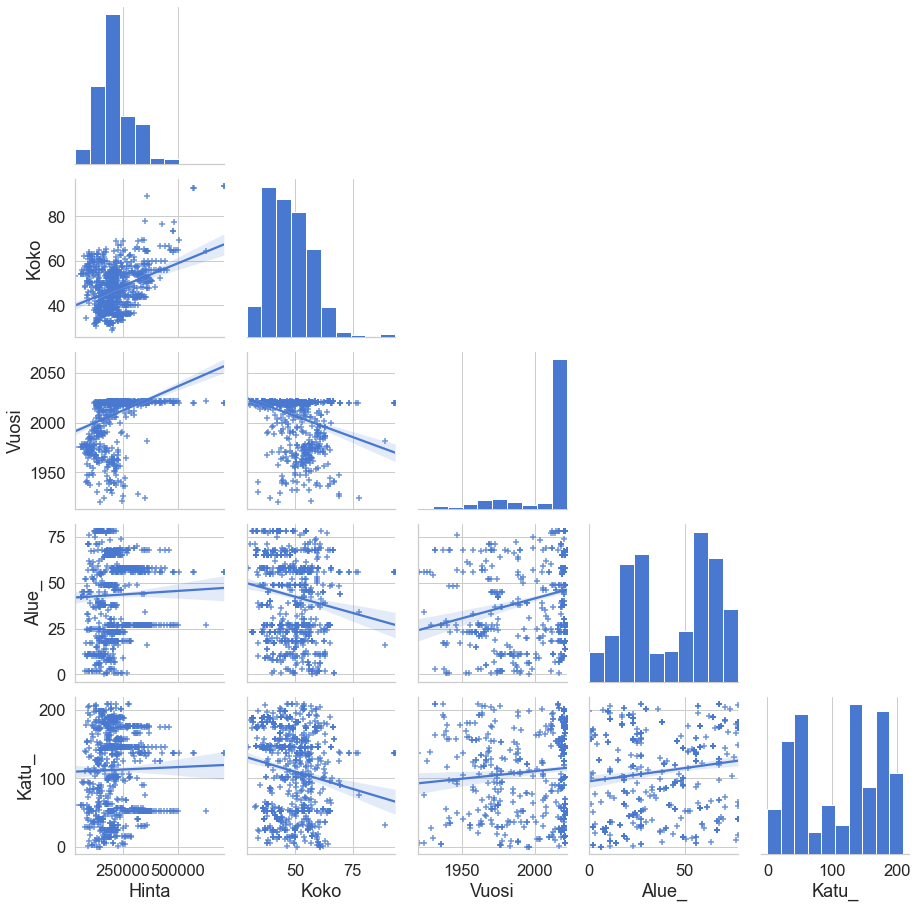

In [236]:
plt.figure(figsize=(20,20));

sns.pairplot(df[['Hinta','Koko', 'Vuosi', 'Alue_', 'Katu_']], corner=True, kind='reg', markers='+');

In [237]:
df.head(10)

Alue                   Osoite     Hinta  Koko  Vuosi  Talotyyppi  \
0    Muotiala        Muotialantie 74 C  208000.0  54.0   2008   Luhtitalo   
1      Kaleva            Teiskontie 13  218000.0  60.0   1954  Kerrostalo   
2      Kaleva       Lemminkäisenkatu 6  185000.0  52.5   1960  Kerrostalo   
3     Tammela           Välimaankatu 7  178000.0  48.6   1932  Kerrostalo   
4       Amuri     Kortelahdenkatu 18 B  174000.0  40.0   1970  Kerrostalo   
5      Kaleva            Sammonkatu 37  219000.0  53.5   1957  Kerrostalo   
6      Kaleva     Kalevan puistotie 11  183000.0  50.0   1955  Kerrostalo   
7      Kaleva            Sammonkatu 37  186000.0  42.5   1957  Kerrostalo   
8  Santalahti         Rantatie 37 C 56  181800.0  38.0   2019  Kerrostalo   
9    Hatanpää  Hatanpään puistokuja 29  249000.0  50.0   2017  Kerrostalo   

   Sauna  Parveke              Katu     m2-hinta  Alue_  Talotyyppi_  Katu_  
0  False    False      Muotialantie  3851.851852     46            1     96  
1  False    False        Teiskontie  3633.333333     23            0    181  
2  False    False  Lemminkäisenkatu  3523.809524     23            0     81  
3  False    False      Välimaankatu  3662.551440     68            0    208  
4  False    False   Kortelahdenkatu  4350.000000      1            0     63  
5  False    False        Sammonkatu  4093.457944     23            0    156  
6  False    False           Kalevan  3660.000000     23            0     48  
7  False    False        Sammonkatu  4376.470588     23            0    156  
8  False    False          Rantatie  4784.210526     65            0    147  
9  False    False         Hatanpään  4980.000000      9            0     27

In [238]:
df.describe()

Hinta        Koko        Vuosi     m2-hinta       Alue_  \
count     990.000000  990.000000   990.000000   990.000000  990.000000   
mean   215244.411548   47.330101  2008.915152  4623.033046   43.307071   
std     83059.223160    9.526237    22.587721  1552.043648   22.039872   
min     32000.000000   29.000000  1920.000000   603.773585    0.000000   
25%    163200.000000   39.000000  2013.000000  3648.148148   24.000000   
50%    199900.000000   46.000000  2020.000000  4434.180278   49.000000   
75%    247900.000000   54.000000  2021.000000  5710.482957   63.750000   
max    708550.000000   93.500000  2022.000000  9717.674419   78.000000   

       Talotyyppi_       Katu_  
count   990.000000  990.000000  
mean      0.137374  112.477778  
std       0.714799   61.737097  
min       0.000000    0.000000  
25%       0.000000   52.000000  
50%       0.000000  135.000000  
75%       0.000000  174.000000  
max       5.000000  209.000000

### Korrelaatioanalyysi

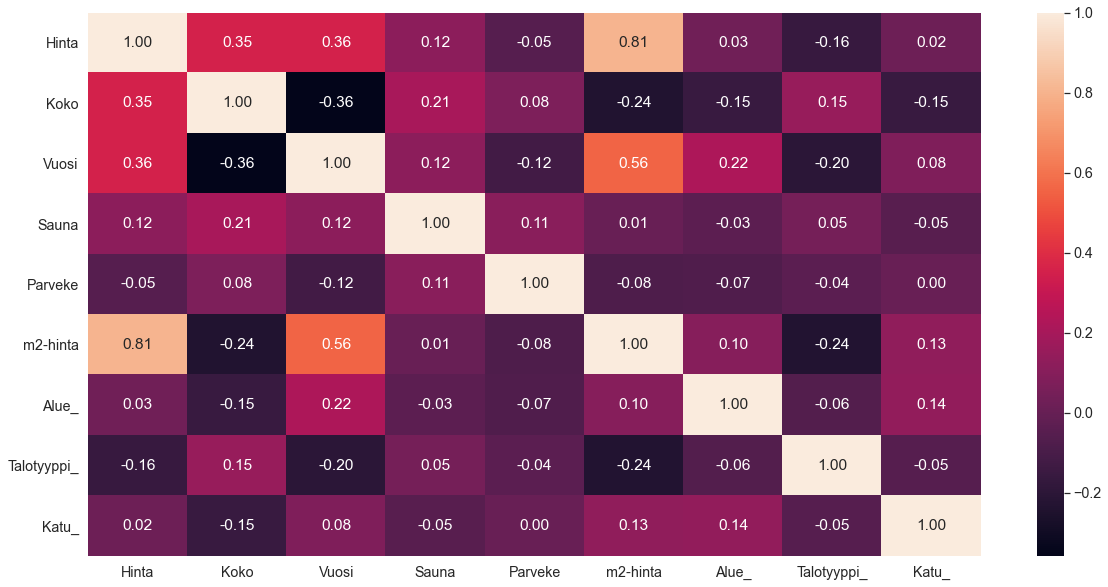

In [239]:
sns.set(font_scale=1.3)
correlation_df = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_df,annot=True,fmt='.2f');

Erotellaan listaan korrelaatiot, jotka ovat suurempia kuin 0.1 ja pienempiä kuin 0.8, tai pienempiä kuin -0.1.

In [240]:
corr_dict=correlation_df['Hinta'].sort_values(ascending=False).to_dict()
important_cols=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        print(key, round(value,5))
        important_cols.append(key)

Vuosi 0.35539
Koko 0.35354
Sauna 0.12162
Talotyyppi_ -0.15848


Sarakkeiden korrelaatiot eivät tällä hetkellä ole kovin vahvoja, mutta valmistumisvuosi näyttäisi korreloivan eniten hinnan kanssa.

### Chi2-analyysi

Kokeillaan erotella tärkeitä piirteitä sklearn-kirjastoon sisältyvällä SelectKBest-funktion avulla.

In [241]:
df.columns

Index(['Alue', 'Osoite', 'Hinta', 'Koko', 'Vuosi', 'Talotyyppi', 'Sauna',
       'Parveke', 'Katu', 'm2-hinta', 'Alue_', 'Talotyyppi_', 'Katu_'],
      dtype='object')

In [242]:
cols = ['Koko', 'Vuosi', 'Sauna', 'Parveke', 'Alue_', 'Katu_']
y = df.Hinta.astype('int')
#X = df.drop(['Hinta', 'Alue', 'Osoite', 'Talotyyppi', 'm2-hinta'], axis=1)
X = df[cols]

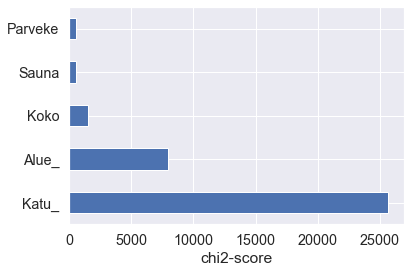

In [243]:
kbest = SelectKBest(score_func=chi2, k=len(X.columns))
kbest.fit(X,y)

feat_score = pd.Series(kbest.scores_, index=X.columns)
feat_score.nlargest().plot(kind='barh');
plt.xlabel('chi2-score');

Tämän testin perusteella asunnon alue olisi huomattavasti merkittävin piirre. 

#### ExtraTreesClassifier -testi
Tämä testi pohjautuu sklearn-kirjaston ExtraTreesClassifier-funktioon. Se muodostaa sarakkeille tärkeyskertoimia, jolloin suurempi arvo on merkki tärkeämmästä piirteestä.

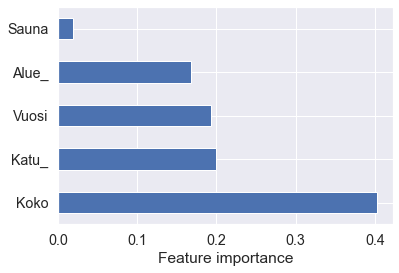

In [244]:
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest().plot(kind='barh');
plt.xlabel('Feature importance');

Tässäkin testissä asunnon koon merkitys painottuu huomattavasti.

Testien perusteella asunnon koko olisi siis tärkein piirre hinnan suhteen. Otetaan malleihin mukaan myös testeissä toiseksi tulleet asuntojen koot.

Tarkastellaan eri piirteiden suhteita hintaan vielä visuaalisesti.

<Figure size 2160x1440 with 0 Axes>

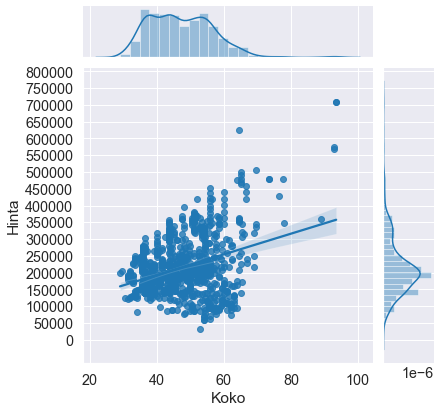

<Figure size 2160x1440 with 0 Axes>

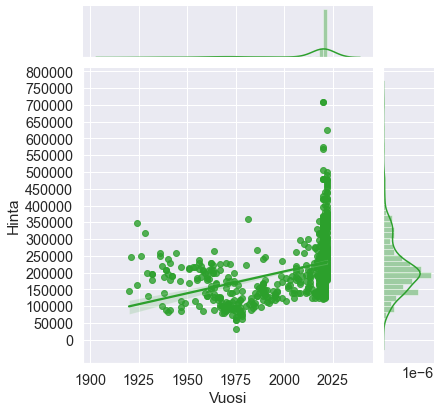

<Figure size 2160x1440 with 0 Axes>

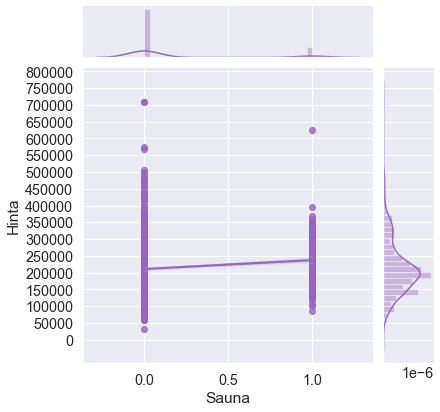

<Figure size 2160x1440 with 0 Axes>

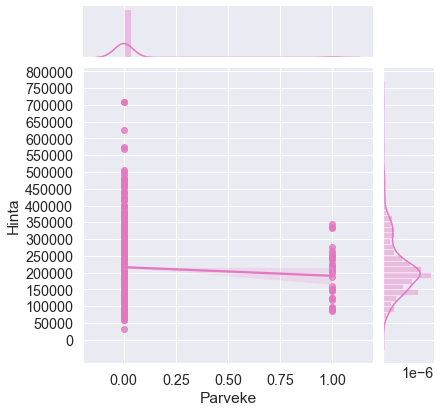

<Figure size 2160x1440 with 0 Axes>

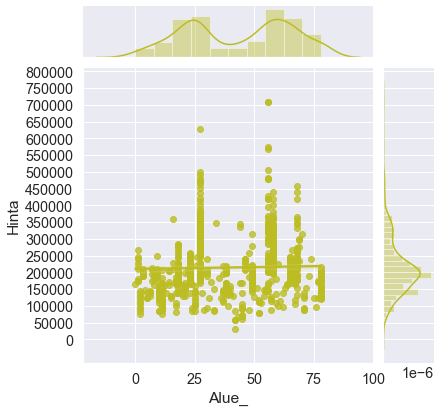

<Figure size 2160x1440 with 0 Axes>

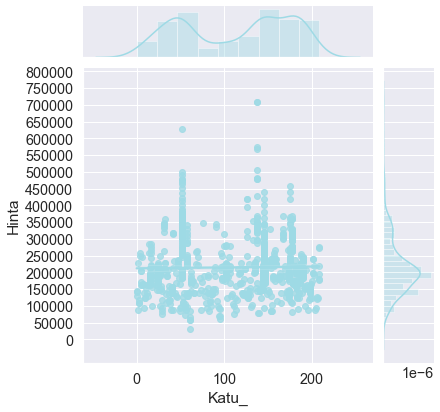

In [245]:
colors=[plt.cm.tab20(each) for each in np.linspace(0, 1, len(X.columns))];
for i,c in zip(X,colors):
    plt.style.use('seaborn-dark-palette');
    plt.figure(figsize=(30,20));
    sns.jointplot(x=i, y='Hinta', data=df, kind="reg",color=c);
    plt.xlabel(str(i));
    plt.yticks(np.arange(0,800001,50000));

## Mallien muodostaminen


### Regressiomallit

In [246]:
cols = ['Koko', 'Vuosi', 'Sauna', 'Parveke', 'Alue_']

scaled_arr = ss.fit_transform(df[cols])
scaled_df = pd.DataFrame(scaled_arr, columns=cols)
scaled_df.head()

Koko     Vuosi     Sauna   Parveke     Alue_
0  0.700515 -0.040536 -0.463383 -0.182765  0.122246
1  1.330673 -2.432424 -0.463383 -0.182765 -0.921844
2  0.542975 -2.166658 -0.463383 -0.182765 -0.921844
3  0.133373 -3.406897 -0.463383 -0.182765  1.120942
4 -0.769853 -1.723716 -0.463383 -0.182765 -1.920540

In [247]:
y = df.Hinta
X = scaled_df[['Koko', 'Vuosi', 'Sauna', 'Parveke', 'Alue_']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
X_train.head()

Koko     Vuosi     Sauna   Parveke     Alue_
983 -1.137445  0.446700 -0.463383 -0.182765  0.984756
615 -0.087182  0.180935  2.158041 -0.182765  0.258432
444 -0.297235  0.535289 -0.463383 -0.182765  0.258432
843  0.280410  0.490995 -0.463383 -0.182765  1.075546
892  0.700515  0.490995  2.158041 -0.182765  0.666989

#### sklearn

In [248]:
time_start = time.time()

l_regr = LinearRegression()
l_regr.fit(X_train, y_train)

train_result = l_regr.predict(X_train)
test_result = l_regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)
print('LinearRegression')
print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

LinearRegression
Time taken to run: 0.027 seconds

Training RMSE: 64148.7939
Testing RMSE: 65862.5827

Training R2: 0.3906
Testing R2: 0.4007


#### XGBoost

In [249]:
time_start = time.time()

xgb_regr = XGBRegressor()
xgb_regr.fit(X_train, y_train )

train_result = xgb_regr.predict(X_train)
test_result = xgb_regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)
print('XGBRegressor')
print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

XGBRegressor
Time taken to run: 0.1499 seconds

Training RMSE: 9504.0575
Testing RMSE: 26493.1866

Training R2: 0.9866
Testing R2: 0.903


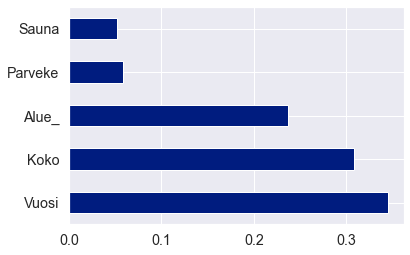

In [250]:
feat_importances = pd.Series(xgb_regr.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

### Luokittelumallit

In [251]:
scaled_df.head()

Koko     Vuosi     Sauna   Parveke     Alue_
0  0.700515 -0.040536 -0.463383 -0.182765  0.122246
1  1.330673 -2.432424 -0.463383 -0.182765 -0.921844
2  0.542975 -2.166658 -0.463383 -0.182765 -0.921844
3  0.133373 -3.406897 -0.463383 -0.182765  1.120942
4 -0.769853 -1.723716 -0.463383 -0.182765 -1.920540

In [252]:
y = df.Alue
#X_clf = scaled_df[[ 'Koko', 'Vuosi', 'Sauna', 'Parveke']]
X_clf = df[[ 'Koko', 'Vuosi', 'Sauna', 'Parveke']]

X_train, X_test, y_train, y_test = train_test_split(X_clf, y, random_state=5)
', '.join(X_clf.columns)

'Koko, Vuosi, Sauna, Parveke'

#### RandomForestClassifier

In [253]:
rf_clf = RandomForestClassifier(random_state=1140, n_estimators=120 , max_depth=20, max_leaf_nodes=230)
rf_clf.fit(X_train, y_train)
result = rf_clf.predict(X_test)
print('RandomForestClassifier')
print ('Confusion Matrix :') 
print(confusion_matrix(y_test, result)) 
print ('Accuracy Score :',accuracy_score(y_test, result)) 
print ('Report : ') 
print (classification_report(y_test, result)) 

RandomForestClassifier
Confusion Matrix :
[[ 1  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 21]]
Accuracy Score : 0.6370967741935484
Report : 
                  precision    recall  f1-score   support

           Amuri       1.00      0.50      0.67         2
          Annala       0.20      0.50      0.29         2
     Armonkallio       0.00      0.00      0.00         2
           Epilä       0.00      0.00      0.00         0
      Haapalinna       0.00      0.00      0.00         1
       Hakametsä       0.00      0.00      0.00         1
      Halkoniemi       0.00      0.00      0.00         0
        Hatanpää       0.33      0.50      0.40         2
      Haukiluoma       0.67      0.50      0.57         4
        Hervanta       0.00      0.00      0.00         4
    Hämeenpuisto       0.00      0.00      0.00         1
         Härmälä       1.00      0.67      0.80         3
 

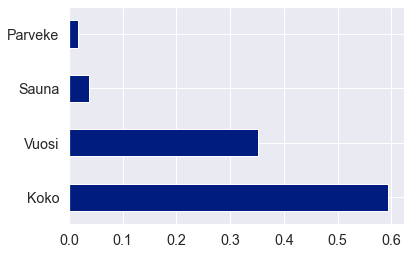

In [254]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

#### XGBClassifier

In [255]:
xgb_clf = XGBClassifier(random_state=1140, n_estimators=120 , max_depth=20, max_leaf_nodes=230)
xgb_clf.fit(X_train, y_train)
result = xgb_clf.predict(X_test)
print('XGBClassifier')
print ('Confusion Matrix :') 
print(confusion_matrix(y_test, result)) 
print ('Accuracy Score :',accuracy_score(y_test, result)) 
print ('Report : ') 
print (classification_report(y_test, result)) 

XGBClassifier
Confusion Matrix :
[[ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 22]]
Accuracy Score : 0.6451612903225806
Report : 
                  precision    recall  f1-score   support

           Amuri       0.00      0.00      0.00         2
          Annala       0.17      0.50      0.25         2
     Armonkallio       0.00      0.00      0.00         2
      Haapalinna       0.00      0.00      0.00         1
       Hakametsä       0.00      0.00      0.00         1
      Halkoniemi       0.00      0.00      0.00         0
        Hatanpää       0.33      0.50      0.40         2
      Haukiluoma       1.00      0.50      0.67         4
        Hervanta       0.25      0.50      0.33         4
    Hämeenpuisto       0.00      0.00      0.00         1
         Härmälä       1.00      0.67      0.80         3
   Härmälänranta       0.67      0.50      0.57        12
      Järv

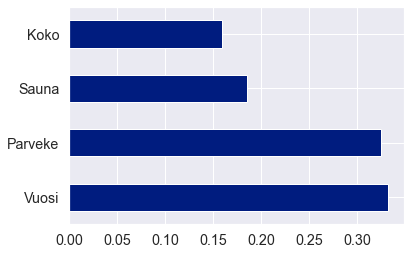

In [256]:
feat_importances = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

## Toimeenpano


In [257]:
area_mean_price = {}
for a in df.Alue.unique():
    if len(df[df.Alue == a]) >= 5:
        area_mean_price[a] = df[df.Alue == a].Hinta.mean();

In [258]:
print(f'Average two-room flat price in Tampere: {round(df.Hinta.mean(),2)}€\n')
print(f'Cheapest two-room flat in Tampere: {round(df.Hinta.min(), 2)}€\n')
print(f'Most expensive two-room flat in Tampere: {round(df.Hinta.max(), 2)}€\n')
print(f'Mean price per square of two-room flats in Tampere: {round(df["m2-hinta"].mean(), 2)}€\n')
print(f'{max(area_mean_price, key=area_mean_price.get)} has the highest mean price of areas with {round(max(area_mean_price.values()), 2)}€\n')

Average two-room flat price in Tampere: 215244.41€

Cheapest two-room flat in Tampere: 32000.0€

Most expensive two-room flat in Tampere: 708550.0€

Mean price per square of two-room flats in Tampere: 4623.03€

Pyynikki has the highest mean price of areas with 322954.04€



### Testisyötteet

In [259]:
regr_test_values = {
    'Koko': [45],
    'Vuosi': [2019],
    'Sauna': [0],
    'Parveke': [0],
    'Alue_':[27]
}

regr_test_df = pd.DataFrame(regr_test_values)

In [260]:
result = xgb_regr.predict(regr_test_df)
price_per_square = round(df.loc[ df['Alue_'].isin(regr_test_values['Alue_']) ]['m2-hinta'].mean()*regr_test_values['Koko'][0], 2)
area = df.loc[ df['Alue_'].isin(regr_test_values['Alue_']) ].iloc[0].Alue
print(f'XGBRegressors prediction: {result[0]}€')
print(f"Price calculated with areas mean price per square: {price_per_square}€")
print(f"Area: {area}")
print(df.loc[ df['Alue_'].isin(regr_test_values['Alue_']) ].describe() )

XGBRegressors prediction: 446291.53125€
Price calculated with areas mean price per square: 277161.67€
Area: Keskusta
               Hinta        Koko        Vuosi     m2-hinta  Alue_  \
count     137.000000  137.000000   137.000000   137.000000  137.0   
mean   303351.233577   49.216058  2013.664234  6159.148139   27.0   
std     82602.904068    8.208570    21.117068  1263.217409    0.0   
min    168000.000000   36.500000  1929.000000  3169.811321   27.0   
25%    229000.000000   43.500000  2020.000000  5057.368421   27.0   
50%    317760.000000   51.000000  2021.000000  6273.684211   27.0   
75%    354010.000000   55.000000  2022.000000  7165.675676   27.0   
max    626790.000000   65.000000  2022.000000  9717.674419   27.0   

       Talotyyppi_       Katu_  
count        137.0  137.000000  
mean           0.0   65.357664  
std            0.0   39.272378  
min            0.0    4.000000  
25%            0.0   52.000000  
50%            0.0   52.000000  
75%            0.0   52.000000

In [271]:
clf_test_values = {
    'Koko': [40],
    'Vuosi': [2019],
    'Sauna': [0],
    'Parveke': [0],
}

clf_test_df = pd.DataFrame(clf_test_values)

clf_result = xgb_clf.predict(clf_test_df)

prob = xgb_clf.predict_proba(clf_test_df).max()
print("Predicted area: {} with certainty of {:f}.\n".format(', '.join(clf_result), prob) )

regr_test_df = clf_test_df
regr_test_df['Alue_'] = df[df.Alue==clf_result[0]].Alue_.values[0]

ss_x = StandardScaler()
scaled_arr = ss_x.fit_transform(regr_test_df)
scaled_df = pd.DataFrame(scaled_arr, columns=regr_test_df.columns)

regr_result = xgb_regr.predict(scaled_df)

print(f'Predicted price: {round(regr_result[0],2)}€')

print(f"\n{', '.join(clf_result)} info:")
df[df.Alue == clf_result[0]].describe()


Predicted area: Pohtola with certainty of 0.399545.

Predicted price: 165927.625€

Pohtola info:


Hinta      Koko   Vuosi     m2-hinta  Alue_  Talotyyppi_  Katu_
count       5.000000   5.00000     5.0     5.000000    5.0          5.0    5.0
mean   147320.000000  39.00000  2019.0  3779.823742   55.0          0.0  141.0
std      2383.694611   1.06066     0.0   124.252327    0.0          0.0    0.0
min    145000.000000  37.50000  2019.0  3580.246914   55.0          0.0  141.0
25%    145900.000000  39.00000  2019.0  3741.025641   55.0          0.0  141.0
50%    145900.000000  39.00000  2019.0  3843.589744   55.0          0.0  141.0
75%    149900.000000  39.00000  2019.0  3843.589744   55.0          0.0  141.0
max    149900.000000  40.50000  2019.0  3890.666667   55.0          0.0  141.0

In [263]:
regr_result = xgb_regr.predict(regr_test_df)
print(f'Predicted price: {round(regr_result[0],2)}€')

Predicted price: 446291.53125€


In [264]:
inverted

array([56])

## Pientä optimointia

In [265]:
vals = {
    'n':[],
    'score':[]
    }
for n in range(230, 350 , 5):
    model = RandomForestClassifier(random_state=1140, n_estimators=120 , max_depth=20,max_leaf_nodes=n)
    model.fit(X_train, y_train)
    result = model.predict(X_test)
    vals['score'].append(accuracy_score(y_test, result))
    vals['n'].append(n)
df_ = pd.DataFrame(vals)

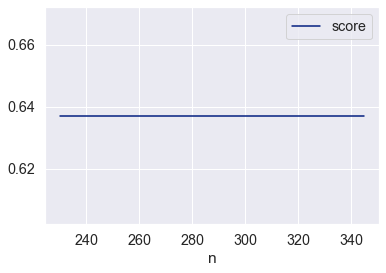

In [266]:
df_.plot(x='n')